## Trabajo Final de Text Mining
### Integrantes: Juan Pablo Pilorget, Pablo Santoro y Mauro Veneziano.
### Objetivo: clasificar sentencias según su status de verdad-mentira.
### El dataset fue obtenido de [acá](http://lit.eecs.umich.edu/~deceptiondetection/)

### Importo las librerías

In [49]:
from tabulate import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import re
import random
import io
import gensim
import struct 
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report, confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
import seaborn as sns
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn import linear_model

### Cargo el dataset

In [151]:
df = pd.read_csv("7Truth7LiesDataset.csv",sep = ',', quotechar="'",escapechar="\\")
df = df.sample(frac=1,random_state=0).reset_index(drop=True).copy()
df = df.rename(columns={"class":"clase"}) # class es palabra reservada
df['clase'] = np.where(df['clase'] == 'truth', 1, 0)

#### Tomo el texto para el clasificador

In [82]:
trainset_texto, testset_texto, trainset_clase, testset_clase =  train_test_split(df.text,df.clase,stratify=df.clase, test_size=0.3, random_state = 123)

### Construyo los tokenizadores y limpiadores

In [83]:
def clean_text(text):
    text = re.sub('(\[")|("\])'," ",text)
    return text.lower().strip()
# Tokenizador
def tokenizer(text):
    return [w for w in word_tokenize(text) if w.isalpha() and len(w)>1]

#### Este tokenizador deja palabras con largo mayor a 1 (A REVISAR). Hay que evaluar si la autorreferencialidad (I) es imoprtante en inglés.

In [84]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t.isalpha() and len(t)>1]

### Construyo el count vectorizer

In [85]:
count_vect = CountVectorizer(preprocessor=clean_text, tokenizer=LemmaTokenizer(), min_df=5,stop_words="english",ngram_range=(1,2))
trainset_texto_token = count_vect.fit_transform(trainset_texto)
testset_texto_token = count_vect.transform(testset_texto)

In [86]:
corpus = " ".join(trainset_texto)
sent_tokenize(corpus)
# reemplazo numeros con " num " y  paso a minuscula 
reg_num = re.compile(r"\d+[.,]?\d*") # Regular expression to search numbers
corpus = reg_num.sub(" NUM ",corpus).lower()  
corpus = sent_tokenize(corpus)

# tiro los tokens no alphabeticos 
trainset_tokenizado = []
for sent in tqdm(corpus):
    tokens = []
    for token in word_tokenize(sent):
        if token.isalpha():
            tokens.append(token)
    trainset_tokenizado.append(tokens)

100%|████████████████████████████████████████████████████████████████████████████| 4077/4077 [00:00<00:00, 4567.12it/s]


In [134]:
corpus[:10]

['i will stay up till  num  am tomorrow.',
 'we  sleep in night i was in hurry yesterday and instead of taking the elevator from second floor i jumped down to earth.',
 'i am in my forties.',
 'there is no evidence that america is an oligarchy.',
 'a blue whale only eats squid.',
 'kodak has gone bankrupt i was lying when i said i love you.',
 'my friend can smell with the help of his fingers.',
 'orange is blue.',
 'santa monica, california, is the west coast terminus of route  num  moon will come in the night i have traveled to mars several times in my life birthday cakes can come lots of flavors, like chocolate, vanilla and red velvet.',
 'my life is very chaotic.']

In [88]:
print ("el corpus tiene",len(trainset), "oraciones y",sum([len(x) for x in trainset]),"palabras")

el corpus tiene 4077 oraciones y 40692 palabras


### Incorporo el código para Word embeddings

In [121]:
GLOVE_6B_50D_PATH = "../Maestría en Data Mining/glove.6B.50d.txt"
encoding="utf-8"

In [122]:
with open(GLOVE_6B_50D_PATH, "rb") as lines:
    wvec = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

In [123]:
X, y = [], []
for i in range(len(trainset_tokenizado)):
    X.append(trainset_tokenizado[i])
    y.append(trainset_clase.tolist()[i])
X, y = np.array(X), np.array(y)
print ("total examples %s" % len(y))

total examples 4077


In [124]:
glove_small = {}
all_words = set(w for words in X for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

In [125]:
model = Word2Vec(X, size=100, window=5, min_count=5, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.vectors)}

In [142]:
# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(tokenizer = LemmaTokenizer(), analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(tokenizer = LemmaTokenizer(),analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(tokenizer = LemmaTokenizer(),analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(tokenizer = LemmaTokenizer(),analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
# SVM - which is supposed to be more or less state of the art 
# http://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf
svc = Pipeline([("count_vectorizer", CountVectorizer(tokenizer = LemmaTokenizer(), analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(tokenizer = LemmaTokenizer(), analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

In [143]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [144]:
# Extra Trees classifier is almost universally great, let's stack it with our embeddings
etree_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_glove_small_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])


In [145]:
all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
    ("glove_small", etree_glove_small),
    ("glove_small_tfidf", etree_glove_small_tfidf),

]

unsorted_scores = [(name, cross_val_score(model, X, y, cv=10).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])


print (tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

model                score
-----------------  -------
w2v_tfidf           0.5126
glove_small_tfidf   0.5013
glove_small         0.4964
mult_nb_tfidf       0.4950
svc_tfidf           0.4947
svc                 0.4925
w2v                 0.4921
bern_nb             0.4898
bern_nb_tfidf       0.4898
mult_nb             0.4852


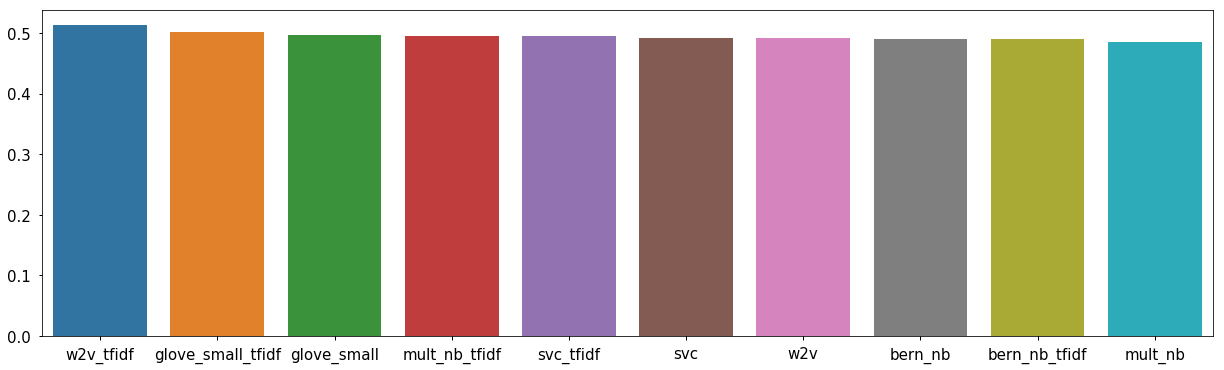

In [149]:
plt.figure(figsize=(21, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])

### Construyo un clasificador Naive Bayes

In [8]:
clf_MNB = MultinomialNB()
# Parametros a variar 
parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]}
# define un grid search a realizar 
grid_search_MNB = GridSearchCV(clf_MNB, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_MNB.fit(trainset_texto_token, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_MNB = grid_search_MNB.best_estimator_
MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()
print ("alpha:",best_clf_MNB.alpha )
print("fscore_cv=",grid_search_MNB.cv_results_["mean_test_score"].max())

MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()

alpha: 3
fscore_cv= 0.5523782385810833


### Grafico los F-scores del Naive Bayes

Text(0.5,1,'p-val=0.0')

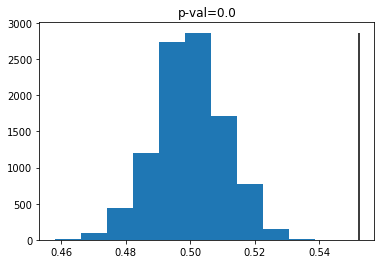

In [9]:
f_measure_random = [f1_score(list(testset_clase), random.sample(list(testset_clase), len(testset_clase)), average="macro") for i in range(10000)]
# Histograma
histograma = plt.hist(f_measure_random)
plt.vlines(MNB_score,ymin=0,ymax=histograma[0].max())
plt.title("p-val="+str((f_measure_random>MNB_score).sum()/len(f_measure_random)))

### Construyo un clasificador Random Forest

In [137]:
clf_RF = RandomForestClassifier(class_weight="balanced",random_state=123)
# Parametros a variar 
parameters = {'n_estimators':[200],'max_features': [10,20,'auto'],"max_depth":[5,10,None] }
# define un grid search a realizar 
grid_search_RF = GridSearchCV(clf_RF, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_RF.fit(trainset_texto_token, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_RF = grid_search_RF.best_estimator_
print ("n_estimators:",best_clf_RF.n_estimators,"; max_features:",best_clf_RF.max_features,"; max_depth:",best_clf_RF.max_depth )
print("fscore_cv=",grid_search_RF.cv_results_["mean_test_score"].max())

n_estimators: 200 ; max_features: 10 ; max_depth: 10
fscore_cv= 0.5604475607388141


### Evalúo el desempeño entre Naive Bayes y Random Forest mediante un histograma

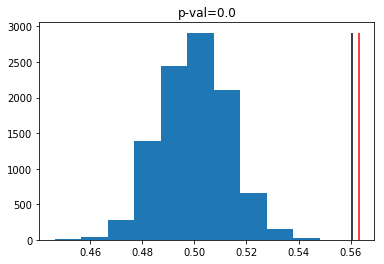

In [138]:
rfscore = grid_search_RF.cv_results_["mean_test_score"].max()
histograma = plt.hist(f_measure_random)
plt.vlines(rfscore,ymin=0,ymax=histograma[0].max()) #En negro Random Forest
plt.title("p-val="+str((f_measure_random>rfscore).sum()/len(f_measure_random)))
plt.vlines(MNB_score,ymin=0,ymax=histograma[0].max(),color="red") #En rojo Naive Bayes

### Grafico las palabras importantes

(array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016]),
 <a list of 9 Text yticklabel objects>)

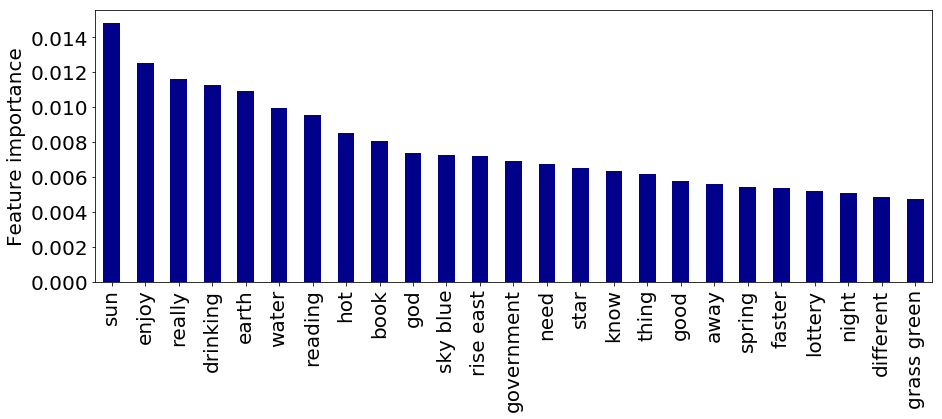

In [139]:
important_words = pd.Series(best_clf_RF.feature_importances_,index=count_vect.get_feature_names()).sort_values(ascending=False)[:25]
important_words.plot(kind="bar",figsize=(15,5),color="darkblue")
plt.ylabel("Feature importance",size=20);plt.xticks(size = 20);plt.yticks(size = 20)
# Es probable que wa y ha sean problema del tokenizador 

### Armo un Pipeline para evaluar usando TF-IDF

In [10]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(preprocessor=clean_text, tokenizer=tokenizer,stop_words="english",ngram_range=(1,2))),
                     ('reduce_dim', SelectKBest(mutual_info_classif)),
                     ('clf',  MultinomialNB())])
    
parameters = {'tfidf__use_idf': [True, False],
              'tfidf__min_df': [3,5,7,10],
              'clf__alpha': [0.001, 0.01,0.1,1,10,100]}

clf_pipe = GridSearchCV(pipeline, parameters, scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)

clf_pipe.fit(trainset_texto, trainset_clase)

best_pipeline = clf_pipe.best_estimator_

KeyboardInterrupt: 

#### Evalúo el Pipeline

In [ ]:
print("Best score:",clf_pipe.best_score_)
print("\nBest parameters set:")
best_parameters = best_pipeline.get_params()
print("use idf:",best_parameters["tfidf__use_idf"])
print("RF max_features:",best_parameters["tfidf__min_df"])
print("RF max_depth:",best_parameters["clf__alpha"])

In [ ]:
#### ACÁ EMPIEZO OTRA PARTE

In [4]:
## VOY A ARMAR UN MODELO PARA COMPLEJIDAD DE LA EXPRESION

In [ ]:
## Empiezo con cosas basicas como algunos signos de puntuacion, longitud de palabras, cantidad de caracteres y cantidad de caracteres por palabra.

In [97]:
coma = trainset_texto.apply(lambda x: len(re.findall(",",x)))
puntos = trainset_texto.apply(lambda x: len(re.findall("\.",x)))
parentesis = trainset_texto.apply(lambda x: len(re.findall("\(",x)))
word_count = trainset_texto.apply(lambda x: len(x.replace("'","").split()))
letras = trainset_texto.apply(lambda x: len(list(re.sub("\W","",x))))
charbyword = letras/word_count

In [98]:
##

In [99]:
trainset_texto.head(10)


7105                  I will stay up till 12 am tomorrow.
2499                                   We  sleep in night
4285    I was in hurry yesterday and instead of taking...
2494                                  I am in my forties.
308     There is no evidence that america is an oligar...
2341                        A blue whale only eats squid.
2827                              Kodak has gone bankrupt
1703                  I was lying when i said i love you.
1423    My friend can smell with the help of his fingers.
6411                                      Orange is blue.
Name: text, dtype: object

In [100]:
## indice de concreción (que tan concreto/abstracto es una palabra) 
conc_rating = pd.read_csv("Concreteness_ratings.txt",sep="	")
conc_rating.head(2)

,Word,Bigram,Conc.M,Conc.SD,Unknown,Total,Percent_known,SUBTLEX,Dom_Pos
0,roadsweeper,0,4.85,0.37,1,27,0.96,0,0
1,traindriver,0,4.54,0.71,3,29,0.90,0,0


In [101]:
## Tomo la concreción promedio de cada frase (sin lematizar)

In [102]:
def conc_src(ele):
    if ele in conc_rating.Word.values:
        score = conc_rating.loc[conc_rating['Word'] == ele,"Conc.M"]
        return float(score)
    else:
        return 0


## no olvidarse de corregir esto, es para la prueba nomas
pru = trainset_texto.sample(500)
concre_media = pru.apply(lambda x: np.mean([conc_src(ele) for ele in x.split()]))

In [103]:
concre_media.head(10)

2341    2.486667
2736    1.613333
4688    1.316667
668     1.878889
6431    2.630000
3076    3.076364
4533    1.940000
6482    1.050000
4358    1.990000
6704    2.685000
Name: text, dtype: float64

In [104]:
### probemos lematizando
concre_media_l = pru.apply(lambda x: np.mean([conc_src(WordNetLemmatizer().lemmatize(ele)) for ele in x.split()]))

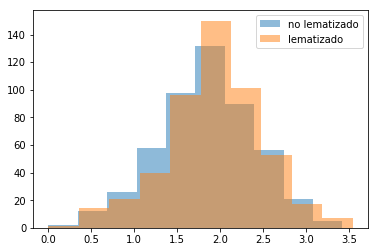

In [105]:
plt.hist(concre_media,alpha = 0.5,label="no lematizado")
plt.hist(concre_media_l,alpha = 0.5,label="lematizado")
plt.legend(loc='upper right')
## hay un toque de diferencia, pero tampoco la pavada. 
## el lematizador despues lo trato de mejorar con pos tagging 

In [106]:
## POR AHORA ME QUEDO SOLAMENTE CON LA MEDIA SIN LEMATIZAR. DESPUES LO SIGO LABURANDO 

In [114]:
concre_media = trainset_texto.apply(lambda x: np.mean([conc_src(ele) for ele in x.split()]))

In [ ]:
## en otro feature cuento la cantidad de palabras con una concreción baja (palabras abstractas)
## pongo un umbral de 2.5 para decir que es baja o alta (el maximo es 5)

In [115]:
def es_abstracta(ele):
    if ele in conc_rating.Word.values:
        score = conc_rating.loc[conc_rating['Word'] == ele,"Conc.M"]
        return float(score) < 2.5
    else:
        return False
    
cant_abstractas = trainset_texto.apply(lambda x: sum([es_abstracta(ele) for ele in x.split()]))

In [129]:
df_comp_train = pd.concat([coma,puntos,parentesis,word_count,letras,charbyword,concre_media, cant_abstractas ],axis=1)
df_comp_train.columns = ["coma","puntos","parentesis","word_count","letras","charbyword","concre_media","cant_abstractas"]

In [137]:
# ACÁ TE AHORRO TIEMPO
#df_comp_train = pd.read_csv("df_comp_train.csv",index_col=0)

,coma,puntos,parentesis,word_count,letras,charbyword,concre_media,cant_abstractas
7105,0,1,0,8,27,3.375000,2.313750,2
2499,0,0,0,4,14,3.500000,2.990000,0
4285,0,1,0,19,82,4.315789,2.260000,7
2494,0,1,0,5,14,2.800000,2.262000,2
308,0,1,0,9,41,4.555556,1.364444,5
2341,0,1,0,6,23,3.833333,2.486667,1
2827,0,0,0,4,20,5.000000,1.320000,1
1703,0,1,0,9,26,2.888889,1.642222,3
1423,0,1,0,10,39,3.900000,2.212000,3
6411,0,1,0,3,12,4.000000,0.530000,1


In [163]:
### en el proximo dejo armado dos modelitos para ir probando.Pero faltan todavia un par de features:
## unas metricas que tengo anotadas y el lexiconde imaginabilidad

5017

In [193]:
mod = linear_model.LogisticRegression()
#mod=  MultinomialNB()
# Parametros a variar 
parameters = {'C':[0.001,0.01,0.1,1,10,100,1000,10000]}
#parameters = {'alpha':[0.001,0.01,0.1,1,10,100,1000,10000]}
# define un grid search a realizar 
grid_search_mod = GridSearchCV(mod, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_mod.fit(df_comp_train, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_mod = grid_search_mod.best_estimator_
mod_score =grid_search_mod.cv_results_["mean_test_score"].max()
print ("C:",best_clf_MNB.C )
#print ("alpha:",best_clf_MNB.C )
print("fscore_cv=",grid_search_mod.cv_results_["mean_test_score"].max())

MNB_score =grid_search_mod.cv_results_["mean_test_score"].max()


C: 0.1
fscore_cv= 0.5193737801908068


In [142]:
from sklearn import linear_model


In [ ]:
### HASTA ACA CON EL DE COMPLEJIDAD. SE PUEDE REPETIR EL MISMO CON OTRA HIPOTESIS. O BUSCANDO OTRAS FEATURES

In [ ]:
## por ejemplo

tiene_I =trainset_texto.apply(lambda x: len(re.findall(r"\bI\b",x)))

In [ ]:
### HASTA ACA CON EL DE COMPLEJIDAD. SE PUEDE REPETIR EL MISMO CON OTRA HIPOTESIS. O BUSCANDO OTRAS FEATURES

In [ ]:
## por ejemplo

tiene_I =trainset_texto.apply(lambda x: len(re.findall(r"\bI\b",x)))

In [ ]:
#### pos tagging

In [129]:
pru= trainset_texto
pru= pru.apply(lambda x: nltk.pos_tag(word_tokenize(clean_text(x))))

columna= []
for element in pru:
    lista = []
    for tupla in element:
        lista.append(tupla[0] + "_" + tupla[1][0])
        
    columna.append(" ".join(lista))
    

trainset_texto_pos = pd.Series(columna)


In [ ]:
pru= testset_texto
pru= pru.apply(lambda x: nltk.pos_tag(word_tokenize(clean_text(x))))

columna= []
for element in pru:
    lista = []
    for tupla in element:
        lista.append(tupla[0] + "_" + tupla[1][0])
        
    columna.append(" ".join(lista))
    

testset_texto_pos = pd.Series(columna)


In [130]:
trainset_texto_pos.head(10)

0    i_N will_M stay_V up_R till_R 12_C am_V tomorr...
1                            we_P sleep_V in_I night_N
2    i_N was_V in_I hurry_N yesterday_N and_C inste...
3                     i_N am_V in_I my_P forties_N ._.
4    there_E is_V no_D evidence_N that_I america_N ...
5         a_D blue_J whale_N only_R eats_V squid_N ._.
6                      kodak_N has_V gone_V bankrupt_J
7    i_N was_V lying_V when_W i_N said_V i_J love_V...
8    my_P friend_N can_M smell_V with_I the_D help_...
9                             orange_N is_V blue_J ._.
dtype: object

In [2]:
count_vect = CountVectorizer(tokenizer=word_tokenize, min_df=5,stop_words="english",ngram_range=(1,2))
trainset_texto_token = count_vect.fit_transform(trainset_texto_pos)
testset_texto_token = count_vect.transform(testset_texto_pos)

NameError: name 'CountVectorizer' is not defined

In [144]:
clf_MNB = MultinomialNB()
# Parametros a variar 
parameters = {'alpha':[0.001,0.003,0.01,0.03,0.1,0.3,1,3]}
# define un grid search a realizar 
grid_search_MNB = GridSearchCV(clf_MNB, parameters,scoring='f1_macro',cv=10,return_train_score=True, n_jobs=-1)
# realiza el grid search evaluando el modelo en un esquema de Cross-Validation
grid_search_MNB.fit(trainset_texto_token, trainset_clase)
# selecciona el mejor modelo (mejor set de parametros)
best_clf_MNB = grid_search_MNB.best_estimator_
MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()
print ("alpha:",best_clf_MNB.alpha )
print("fscore_cv=",grid_search_MNB.cv_results_["mean_test_score"].max())

MNB_score =grid_search_MNB.cv_results_["mean_test_score"].max()

alpha: 3
fscore_cv= 0.5927181545134423
